
From¶
https://www.thepythoncode.com/article/stock-price-prediction-in-python-using-tensorflow-2-and-keras

other idea https://hackernoon.com/forecasting-market-movements-using-tensorflow-fb73e614cd06

In [121]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# TensorFlow and tf.keras
#import tensorflow as tf
#from tensorflow import keras

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from yahoo_fin import stock_info as si
from collections import deque
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import datetime
import time
import os

#import talib

In [122]:

def load_data(ticker, 
                n_steps=50, 
                scale=True, 
                shuffle=True,
                lookup_step=1, 
                test_size=0.2,
                feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        #df = si.get_data(ticker)
        df = si.get_data(ticker=ticker, start_date=start_date, end_date=end_date)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler

        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 59 (that is 50+10-1) length
    # this last_sequence will be used to predict in future dates that are not available in the dataset
    last_sequence = list(sequences) + list(last_sequence)
    # shift the last sequence by -1
    last_sequence = np.array(pd.DataFrame(last_sequence).shift(-1).dropna())
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    # reshape X to fit the neural network
    X = X.reshape((X.shape[0], X.shape[2], X.shape[1]))
    # split the dataset
    result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, test_size=test_size, shuffle=shuffle)
    # return the result
    return result

In [123]:
# create the model

def create_model(input_length, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop"):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            model.add(cell(units, return_sequences=True, input_shape=(None, input_length)))
        elif i == n_layers - 1:
            # last layer
            model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [124]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, None, 256)         314368    
_________________________________________________________________
dropout_15 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
lstm_16 (LSTM)               (None, None, 256)         525312    
_________________________________________________________________
dropout_16 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [146]:
# training the model
import time

start_date = '2000-12-31'
end_date = '2019-12-31'


# Window size or the sequence length
N_STEPS = 50
# Lookup step, 1 is the next day
LOOKUP_STEP = 1 #30 #10 #1
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 3
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
### training parameters
# mean squared error loss
LOSS = "mse"
OPTIMIZER = "rmsprop"
BATCH_SIZE = 64

# TODO: realistic
EPOCHS = 300 # 10 ##300
# Apple stock market
ticker = 'MSFT' # "AAPL"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save
model_name = f"{date_now}_{ticker}-{LOSS}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"




In [147]:
# Clear any logs from previous runs
!rm -rf ./logs/ 
# create these folders if they does not exist
import os

if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [148]:
## hacking

#tf.summary.create_file_writer('logs/fit').as_default()

# load the data
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)
# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER)
# some tensorflow callbacks
#checkpointer = ModelCheckpoint(os.path.join("results", model_name), save_best_only=True, verbose=1)
#tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

# see https://www.tensorflow.org/tensorboard/get_started
# some bug local i cannot unset 'logs/hparam_tuning'
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


#tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
#tf.get_logger().setLevel('INFO')
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[tensorboard_callback],
                    verbose=0)


model.save(os.path.join("results", model_name) + ".h5")

print('done fit and save...')

done fit and save...


In [149]:
# Load the TensorBoard notebook extension
#%load_ext tensorboard
#%tensorboard --logdir logs/fit

In [150]:
## model testing

data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE,
                feature_columns=FEATURE_COLUMNS, shuffle=False)

# construct the model - do NOT need to redo this..
###model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
###                     dropout=DROPOUT, optimizer=OPTIMIZER)

model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)



In [151]:
# evaluate the model
mse, mae = model.evaluate(data["X_test"], data["y_test"])
# calculate the mean absolute error (inverse scaling)
mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform(mae.reshape(1, -1))[0][0]
print("Mean Absolute Error:", mean_absolute_error)



946/946 [==============================] - 0s 266us/sample - loss: 2.0488e-04 - mean_absolute_error: 0.0110
Mean Absolute Error: 13.321205


In [152]:
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][:N_STEPS]
    # retrieve the column scalers
    column_scaler = data["column_scaler"]
    # reshape the last sequence
    last_sequence = last_sequence.reshape((last_sequence.shape[1], last_sequence.shape[0]))
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    predicted_price = column_scaler["adjclose"].inverse_transform(prediction)[0][0]
    return predicted_price



In [153]:
# predict the future price
future_price = predict(model, data)
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")

Future price after 1 days is 155.46$


In [154]:
def plot_graph(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    # last 200 days, feel free to edit that
    plt.plot(y_test[-200:], c='b')
    plt.plot(y_pred[-200:], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

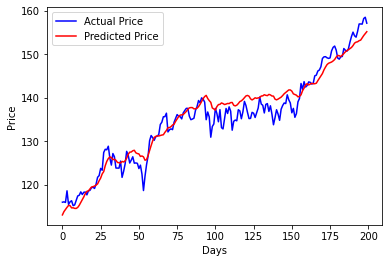

In [155]:
plot_graph(model, data)

In [80]:
def get_accuracy(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    y_pred = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_pred[LOOKUP_STEP:]))
    y_test = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_test[LOOKUP_STEP:]))
    return accuracy_score(y_test, y_pred)

In [91]:
print('{}:, Accuracy Score:{}'.format(LOOKUP_STEP, get_accuracy(model, data)))



1:, Accuracy Score:0.5374269005847954
